# test to load local package

## try on dataset c20200927 c20201113 in folder SPOTSAR/test_data


In [1]:
# import external packages
import numpy as np
import pandas as pd
import numba
from numba import vectorize
import glob # for file search
import copy
import os # operating system stuff
import re # regex
import fastparquet # fast read/write for large data structures
import sklearn.preprocessing as pre # for data normalisation
from sklearn.metrics import pairwise_distances

import geopandas as gpd
import rasterio as rio
import rasterio.mask
from rasterio.plot import plotting_extent
from shapely.geometry import Polygon
from shapely.geometry.point import Point
import datetime
import pyproj
from pyproj import CRS
from inpoly import inpoly2 # for fast inpolygon checks
import utm


import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
from matplotlib import cm as mpl_cm
from matplotlib import colors as mcolors 

from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar scaling
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FormatStrFormatter

import seaborn as sns
from matplotlib import rc_file_defaults
rc_file_defaults()
# sns.set(style=None, color_codes=True)



from shapely.geometry import Polygon
from shapely.geometry.point import Point
import datetime

import configparser

from cmcrameri import cm # for scientific colourmaps

###########################
# import main local package
import SPOTSAR_main as sm


In [2]:
import sys
modulenames = set(sys.modules) & set(globals())
allmodules = [sys.modules[name] for name in modulenames]
print(allmodules)

[<module 'utm' from '/Applications/anaconda3/envs/PhD/lib/python3.8/site-packages/utm/__init__.py'>, <module 'fastparquet' from '/Applications/anaconda3/envs/PhD/lib/python3.8/site-packages/fastparquet/__init__.py'>, <module 'copy' from '/Applications/anaconda3/envs/PhD/lib/python3.8/copy.py'>, <module 'sys' (built-in)>, <module 'configparser' from '/Applications/anaconda3/envs/PhD/lib/python3.8/configparser.py'>, <module 'os' from '/Applications/anaconda3/envs/PhD/lib/python3.8/os.py'>, <module 'glob' from '/Applications/anaconda3/envs/PhD/lib/python3.8/glob.py'>, <module 'rasterio' from '/Applications/anaconda3/envs/PhD/lib/python3.8/site-packages/rasterio/__init__.py'>, <module 're' from '/Applications/anaconda3/envs/PhD/lib/python3.8/re.py'>, <module 'datetime' from '/Applications/anaconda3/envs/PhD/lib/python3.8/datetime.py'>, <module 'pyproj' from '/Applications/anaconda3/envs/PhD/lib/python3.8/site-packages/pyproj/__init__.py'>, <module 'numba' from '/Applications/anaconda3/envs

In [3]:
################ Define user INPUTS #######################
######## please edit the values of this block only ########
###########################################################

# define hillshade file
HS_FILE = './test_data/DEM/TDX_Merapi_WGS84_HS.tif'

# define lon and lat files
lon_file = './test_data/CSK_dsc/geo/20200910.lon'
lat_file = './test_data/CSK_dsc/geo/20200910.lat'

# define parameter text file
PARAM_FILE = './test_data/CSK_dsc/params.txt'

# define map region of interest
lon_lims = [110.425, 110.45]
lat_lims = [-7.555, -7.535]

# define colour range {min max} (min = -max)
vmax = 3 # range of colourscale in meters

# define file names for data, lon and lat
directory_path = "./test_data/CSK_dsc/OFFS/"
# define path to ccp and ccs files
directory_path_ccs = "./test_data/CSK_dsc/CCS/"

# Set the regular expression pattern to match the file names
pattern = r"^c[0-9]+_c[0-9]+_disp_[0-9]+_[0-9]+\.txt$"
# Set the regular expression pattern to match the ccs file names
pattern_ccs = r"^c[0-9]+_c[0-9]+_ccs_[0-9]+_[0-9]+$"



In [4]:
# open hillshade file and re-order offset and CCS files

# open hill shade file with rasterio
DEM_HS = rio.open(HS_FILE)
shading = DEM_HS.read(1,masked=True) # rasterio bands are indexed from 1

# extract DEM extent
DEM_extent=[DEM_HS.bounds.left,DEM_HS.bounds.right,DEM_HS.bounds.bottom,DEM_HS.bounds.top]

# reorder file using Post_processing.reorder_files
matching_files = sm.Post_processing.reorder_files(directory_path,pattern,0)
matching_files_ccs = sm.Post_processing.reorder_files(directory_path_ccs,pattern_ccs,0)

# test if file ordering has worked
print(matching_files)
print(matching_files_ccs)

['c20200927_c20201113_disp_42_20.txt', 'c20200927_c20201113_disp_74_36.txt', 'c20200927_c20201113_disp_108_52.txt', 'c20200927_c20201113_disp_140_68.txt', 'c20200927_c20201113_disp_174_84.txt', 'c20200927_c20201113_disp_206_100.txt', 'c20200927_c20201113_disp_240_116.txt', 'c20200927_c20201113_disp_272_132.txt', 'c20200927_c20201113_disp_306_148.txt', 'c20200927_c20201113_disp_340_164.txt', 'c20200927_c20201113_disp_372_180.txt']
['c20200927_c20201113_ccs_42_20', 'c20200927_c20201113_ccs_74_36', 'c20200927_c20201113_ccs_108_52', 'c20200927_c20201113_ccs_140_68', 'c20200927_c20201113_ccs_174_84', 'c20200927_c20201113_ccs_206_100', 'c20200927_c20201113_ccs_240_116', 'c20200927_c20201113_ccs_272_132', 'c20200927_c20201113_ccs_306_148', 'c20200927_c20201113_ccs_340_164', 'c20200927_c20201113_ccs_372_180']


In [5]:
# read parameters from text file
config = configparser.ConfigParser()
config.read(PARAM_FILE)
width = int(config.get('params', 'width'))
lines = int(config.get('params', 'lines'))
width_ccs = int(config.get('params', 'width_ccs'))
lines_ccs = int(config.get('params', 'lines_ccs'))
r_start = int(config.get('params', 'r_start'))
a_start = int(config.get('params', 'a_start'))
r_step = int(config.get('params', 'r_step'))
a_step = int(config.get('params', 'a_step'))
heading = float(config.get('params', 'heading'))
mean_inc = float(config.get('params', 'mean_inc'))

In [6]:
# load data from files into classes

datastack = sm.Post_processing.MultiKernel(directory_path,
                                           matching_files,
                                           directory_path_ccs,
                                           matching_files_ccs,
                                           lat_file,
                                           lon_file,
                                           heading,
                                           mean_inc,
                                           lines_ccs,
                                           width_ccs)
datastack.get_params_from_file_name()
datastack.get_latlon_from_file(width)
datastack.add_lat_lon_to_data(r_start,a_start)
datastack.crop_stack_ccs(r_step,a_step)
stacked_data = datastack.assign_data_to_stack(r_step,a_step)


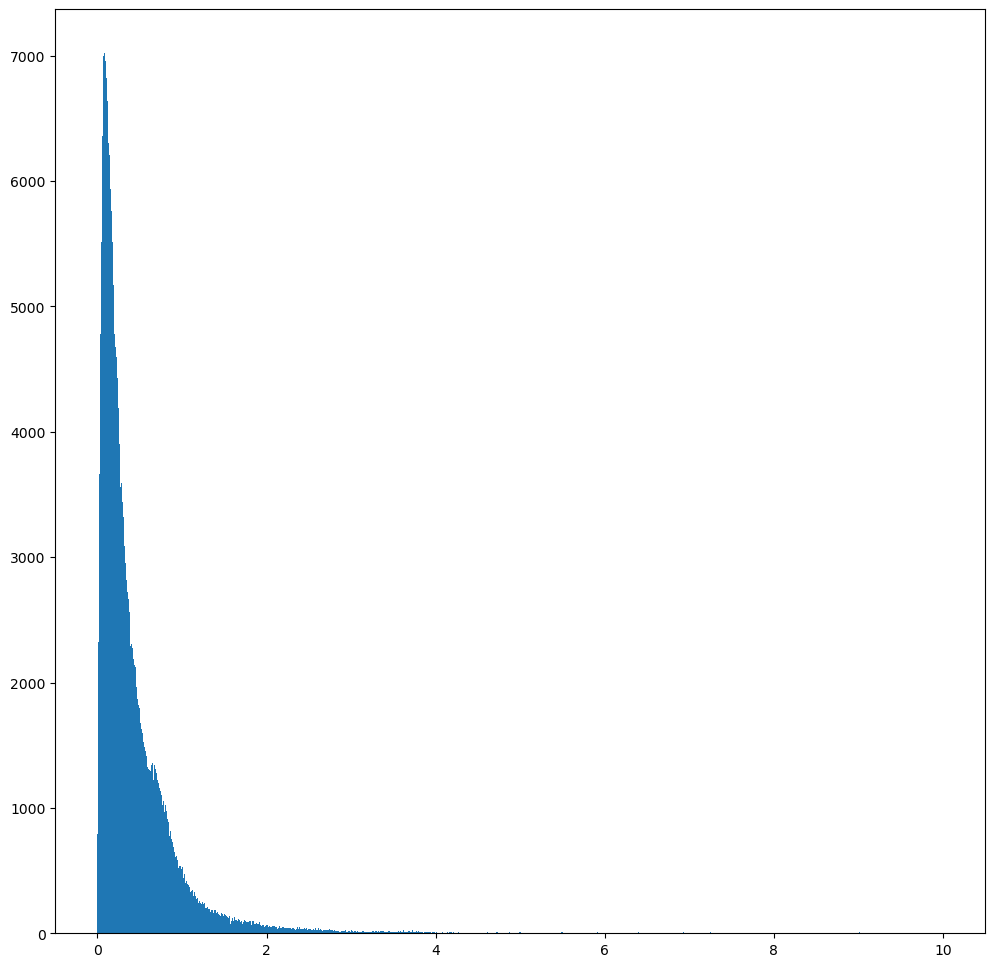

In [7]:
# test some plotting functions

test_obj = stacked_data[2]
sm.plot.plot_hist(test_obj,'Mag_vec', 1000, [0,10])


In [9]:
%matplotlib osx
import random
random.seed(10)

n_plots = 50
indeces = random.randint(0,np.size(test_obj.R_off_vec))
for i in range(n_plots):
    idx = random.randint(0,np.size(test_obj.R_off_vec))
    sm.plot.plot_rand_vec(test_obj,idx,5,0.002,0.3,2)

/Users/markbemelmans/Documents/PhD/projects/SPOTSAR/SPOTSAR_main/plot/plot_rand_vec.py:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig=plt.figure(figsize=(10,10))


In [9]:
plt.close('all')

In [9]:
# [X_off,X_off_vec,Y_off_vec,Lat_off_vec,Lon_off_vec,R_idx_vec,A_idx_vec,Row_index_vec,Col_index_vec,A_win,R_win] = test_obj.get_data_4_wL2()
# print('loaded the data')
# test_obj.wL2 = sm.Post_processing.run_wL2(X_off,X_off_vec,Y_off_vec,Lat_off_vec,Lon_off_vec,R_idx_vec,A_idx_vec,Row_index_vec,Col_index_vec,A_win,R_win)


loaded the data


KeyboardInterrupt: 

In [9]:
# # test long calculation of local weighted L2
# test_obj.calc_local_L2()


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


array([[2.46581662, 0.78486544, 0.54693371, ...,        nan,        nan,
               nan],
       [0.86615216, 0.94830574, 0.57332405, ..., 1.35627136, 1.1144272 ,
        1.95685046],
       [0.90722584, 0.99049412, 0.56393025, ...,        nan, 1.96350686,
        1.34036068],
       ...,
       [0.56595792, 0.54613226, 0.7576762 , ...,        nan,        nan,
               nan],
       [0.48182459,        nan, 0.74297518, ...,        nan,        nan,
               nan],
       [2.36241424,        nan,        nan, ..., 0.47892181, 0.54291586,
        1.0033774 ]])

In [15]:

# sm.plot.plot_vec_attr(test_obj,'wL2',5,50,[0,50],1,shading,DEM_extent)


NameError: name 'CRS' is not defined